# Import librairies et jeux de données

In [1]:
import pandas as pd
import numpy as np

#pour les représentations graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#pour centrer-réduire
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#pour les test statistiques
from scipy.stats import ttest_ind, shapiro, anderson, kstest

#pour les modèles non-supervisés
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#pour les modèles supervisés
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Pour évaluer les performances des modèles
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score
from scipy.optimize import linear_sum_assignment

In [2]:
df = pd.read_csv("billets.csv", sep=';')

# Description

In [3]:
df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [4]:
df.shape

(1500, 7)

In [5]:
df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

La moyenne est proche de la médiane et le 3ème quartile est proche du max pour toutes les variables, on peut donc raisonnablement considérer qu'il n'y a pas de valeurs extrêmes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


La colonne margin_low contient 37 valeurs manquantes, il va falloir la traiter car les modèles de ML n'acceptent par les NaN.

In [7]:
df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [8]:
df.groupby('is_genuine').mean()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                
False       171.90116    104.19034     104.14362    5.215935    3.35016   
True        171.98708    103.94913     103.80865    4.116097    3.05213   

               length  
is_genuine             
False       111.63064  
True        113.20243

In [9]:
#On commence par transformer la colonne is_genuine en integer au lieu de booléen

df.loc[df['is_genuine'] == True, 'is_genuine'] = 1
df.loc[df['is_genuine'] == False, 'is_genuine'] = 0

In [10]:
df['is_genuine'] = df['is_genuine'].apply(pd.to_numeric)

In [11]:
df.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

# Traitement valeurs manquantes

In [12]:
# Supprimer les lignes où margin_low est manquant (pour le test)
df_dropna = df.dropna(subset=['margin_low']).copy()

In [13]:
df_dropna.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [14]:
df_dropna.shape

(1463, 7)

### Division train test

In [15]:
#On définit notre variable cible y et nos prédicteurs X
X = df_dropna.drop(columns=['margin_low', 'is_genuine'])
y = df_dropna['margin_low']

In [16]:
#On sépare notre jeu de données en entraînement (60%) et test (40%). Je choisi un jeu de test relativement conséquent car j'ai un petit jeu de données.
train, test = train_test_split(df_dropna, test_size=0.40, random_state=42)

In [17]:
X_train = train.drop(columns=['margin_low', 'is_genuine'])
y_train = train['margin_low']
X_test = test.drop(columns=['margin_low', 'is_genuine'])
y_test = test['margin_low']

In [18]:
X_train.head()

diagonal  height_left  height_right  margin_up  length
453     172.54       104.05        103.78       2.93  114.14
326     171.42       103.47        103.82       3.05  112.70
1075    172.02       104.51        103.69       3.39  112.35
776     171.26       103.87        104.41       2.88  113.90
434     172.04       103.82        103.99       3.14  113.23

In [19]:
#Je standardise mes données pour réduire l'effet taille.
scaler = StandardScaler()

# 1. Je fit sur le train uniquement. En effet fiter sur les données de test serait une forme de data leakage car nous se sommes pas sensé connaître les dimensions des billets de test dans la phase d'entraînement.
scaler.fit(X_train)

# 2. J'applique le transform sur train et test en conservant les index
X_train_std = pd.DataFrame(scaler.transform(X_train), 
                              index=X_train.index, 
                              columns=X_train.columns)

X_test_std = pd.DataFrame(scaler.transform(X_test), 
                             index=X_test.index, 
                             columns=X_test.columns)

In [20]:
X_train_std.head()

diagonal  height_left  height_right  margin_up    length
453   1.904488     0.047222     -0.429943  -0.996748  1.683825
326  -1.788026    -1.869790     -0.307182  -0.466023  0.019986
1075  0.190107     1.567612     -0.706155   1.037697 -0.384419
776  -2.315528    -0.547713      1.503540  -1.217884  1.406518
434   0.256045    -0.712972      0.214551  -0.067980  0.632371

### Entrainement du modèle

In [21]:
lr_model = sm.OLS(y_train, sm.add_constant(X_train_std)).fit()

### Sélection des features

#### Analyse exploratoire

Bien que la variable is genuine apparaisse dans cette analyse exploratoire, je ne commenterai pas sa relation avec margin_low car j'ai choisi de ne pas la garder.

In [22]:
# Résumé statistique des variables
train.describe()

is_genuine    diagonal  height_left  height_right  margin_low  \
count  877.000000  877.000000   877.000000    877.000000  877.000000   
mean     0.665906  171.962338   104.035713    103.920091    4.473637   
std      0.471942    0.303489     0.302727      0.326023    0.660899   
min      0.000000  171.050000   103.220000    102.910000    2.980000   
25%      0.000000  171.750000   103.820000    103.710000    4.020000   
50%      1.000000  171.960000   104.040000    103.910000    4.300000   
75%      1.000000  172.180000   104.240000    104.150000    4.860000   
max      1.000000  172.890000   104.880000    104.950000    6.700000   

        margin_up      length  
count  877.000000  877.000000  
mean     3.155371  112.682702  
std      0.226235    0.865963  
min      2.580000  109.970000  
25%      2.990000  112.050000  
50%      3.140000  112.950000  
75%      3.310000  113.330000  
max      3.910000  114.320000

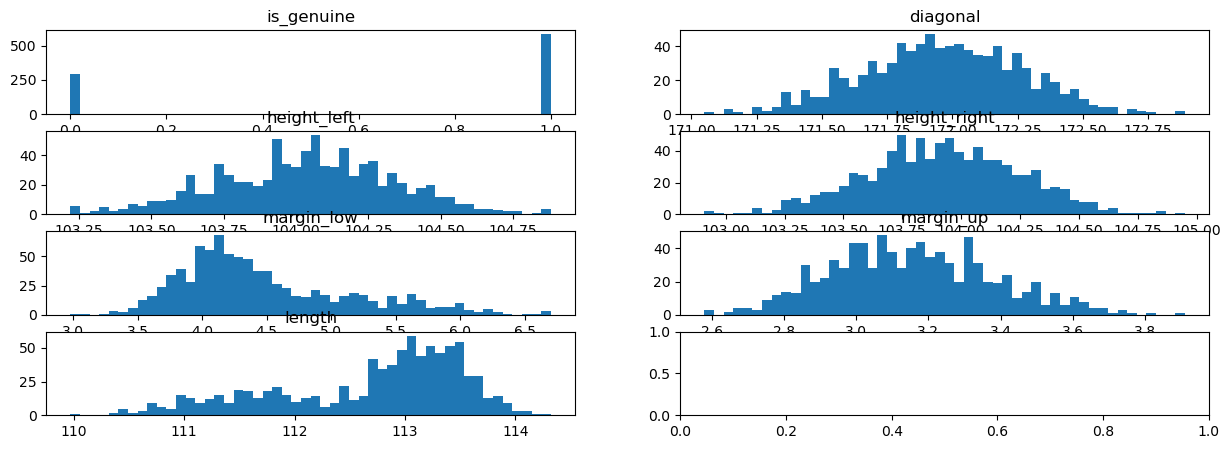

In [23]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(4, 2, figsize=(15, 5))
axs = axs.ravel()

for i, column in enumerate(train.columns):
    axs[i].hist(train[column], bins=50)
    axs[i].set_title(column)

plt.show()

Les variables ont l'air d'être plutôt normalement distribuées sauf pour margin_low et length.

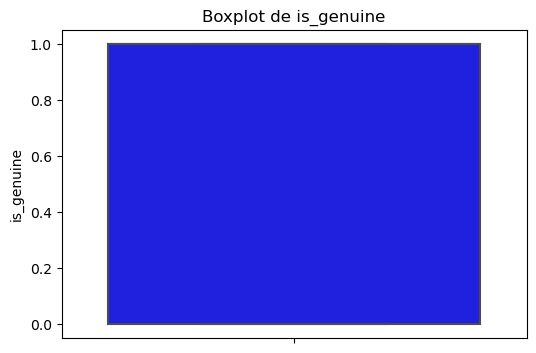

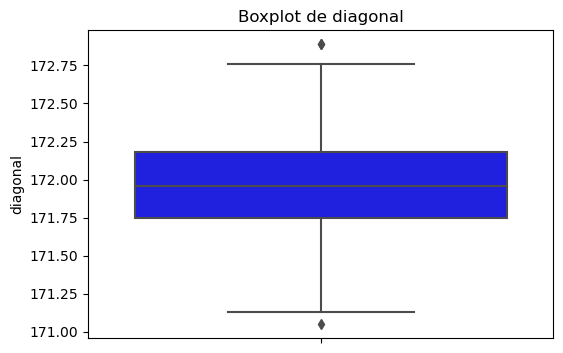

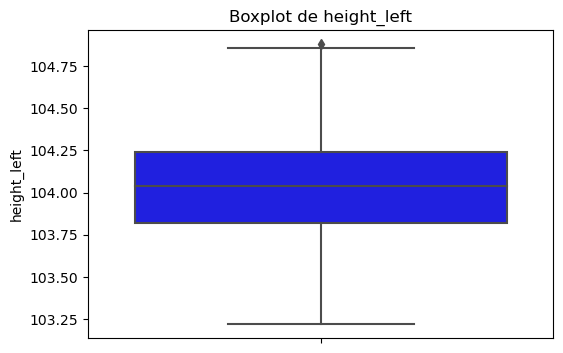

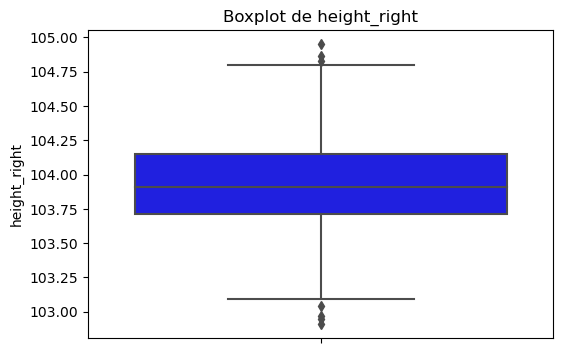

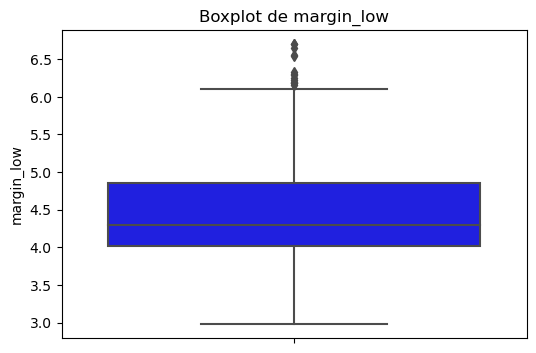

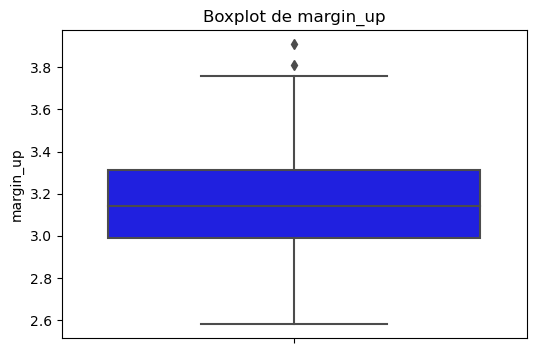

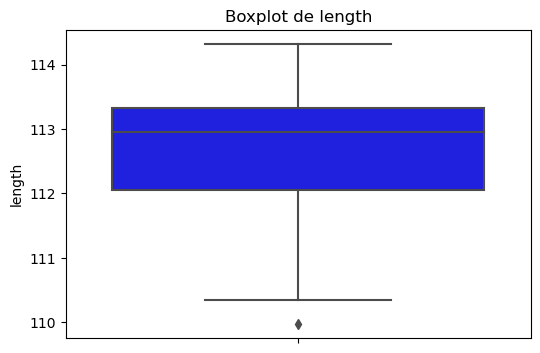

In [24]:
# Affichage des boxplots pour chaque variable numérique
num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, y=col, color="blue")
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)
    plt.show()

margin_low a quelques valeurs atypiques mais qui ne semblent pas être incohérentes, je les garde.

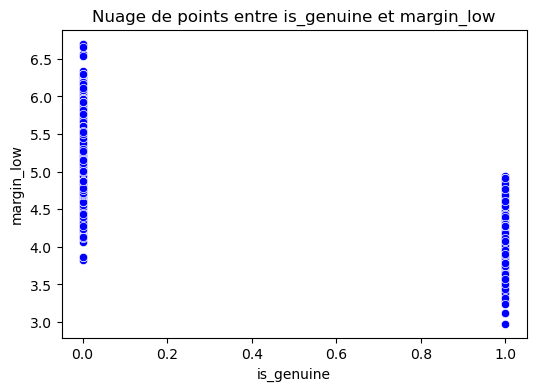

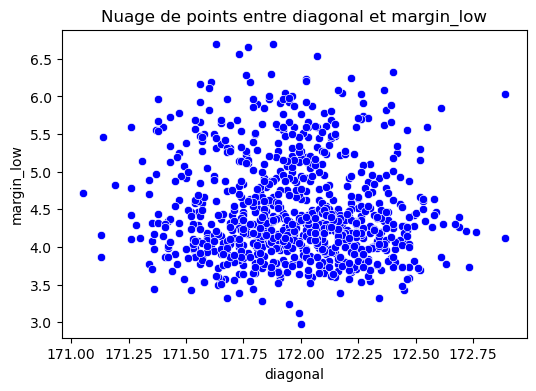

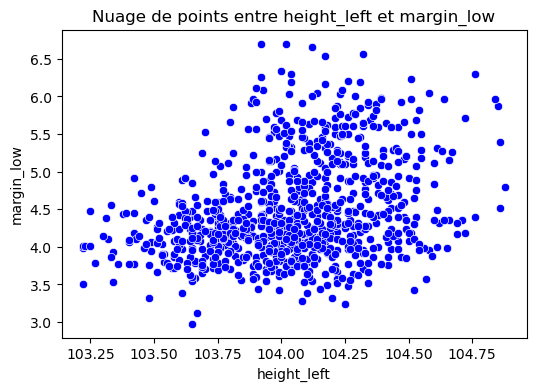

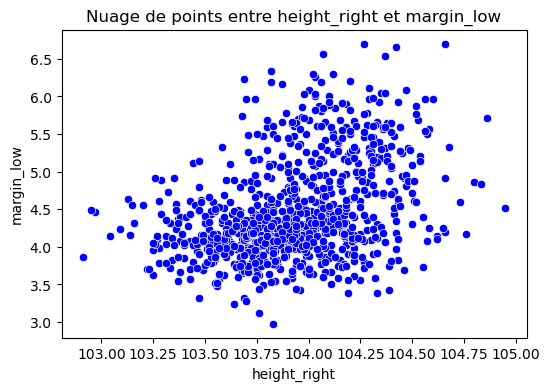

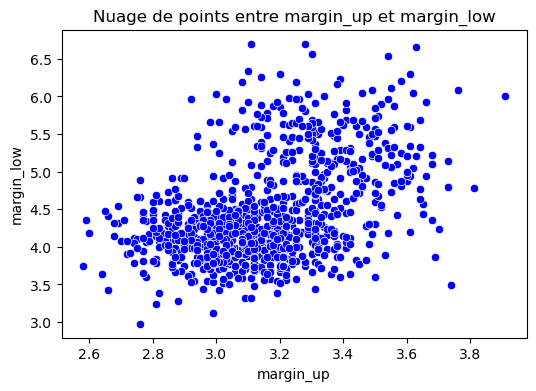

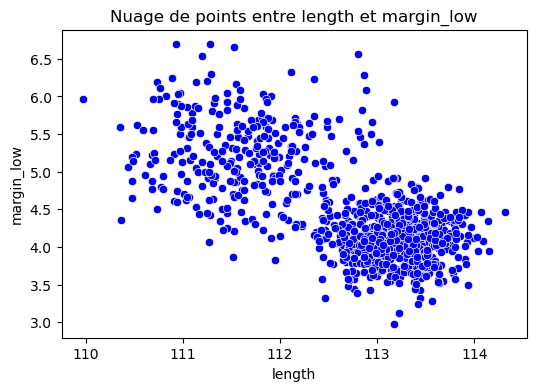

In [25]:
# Affichage des nuages de points entre la variable d'intérêt et toutes les autres variables
target_col = "margin_low"
num_cols = list(train.select_dtypes(include=["float64", "int64"]).columns)
num_cols.remove(target_col)

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y=target_col, color="blue")
    plt.title(f"Nuage de points entre {col} et {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.show()

La variables avec laquelle margin_low semble avoir principalement une relation linéaire est la variable length: quand margin_low augmente, length diminue, et inversement.
On peut aussi voir assez clairement 2 clusters qui correspondent probablement à a différence entre les vrais et les faux billets.

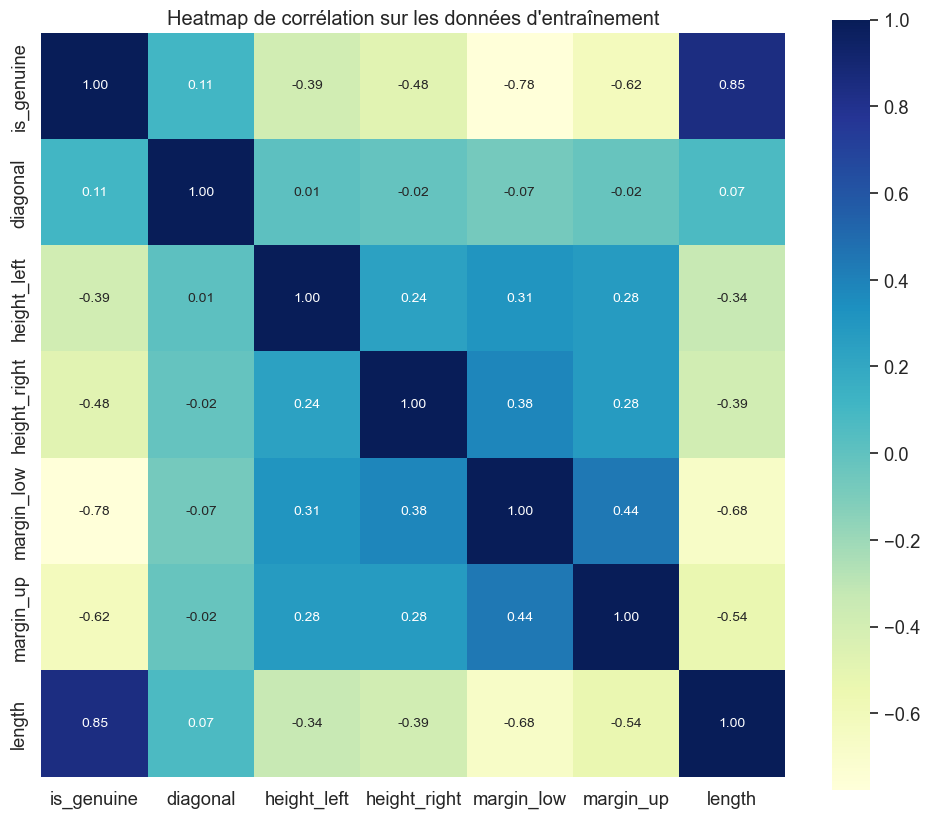

In [26]:
# Calcul de la matrice de corrélation sur les données d'entraînement
corr_matrix_train = train.corr()


sns.set(font_scale=1.2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, cmap="YlGnBu", annot=True, annot_kws={"size": 10}, square=True, fmt=".2f")

plt.title("Heatmap de corrélation sur les données d'entraînement")
plt.show()

In [27]:
# Extraction des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
corr_threshold = 0.6
corr_threshold_neg = -0.6
corr_vars = corr_matrix_train[(abs(corr_matrix_train["margin_low"]) > corr_threshold) | (abs(corr_matrix_train["margin_low"]) < corr_threshold_neg) ].index.tolist()

# Affichage des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
print("Variables ayant une corrélation supérieure à 0.6 ou inférieure à -0.6 avec la variable d'intérêt (margin_low) :\n")
print(corr_vars)

Variables ayant une corrélation supérieure à 0.6 ou inférieure à -0.6 avec la variable d'intérêt (margin_low) :

['is_genuine', 'margin_low', 'length']


Comme vu précédemment, c'est la variable length qui semble être la plus corrélée avec margin_low avec un coefficient de corrélation de -0.65.

In [28]:
# Extraction des couples de variables ayant une corrélation supérieure à 0.8
corr_threshold = 0.8
corr_threshold_neg = -0.8
corr_pairs = {}

for col in corr_matrix_train.columns:
    corr_pairs[col] = []
    corr_values = corr_matrix_train[(abs(corr_matrix_train[col]) > corr_threshold) | (abs(corr_matrix_train[col]) < corr_threshold_neg)][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :

is_genuine - length
length - is_genuine


Les variables is_genuine et length sont très corréles entre elles (multicolinéarité). Comme j'ai choisi de ne pas garder is genuine dans mes variables prédictrices, je continue (sinon il aurait fallu en supprimer une des 2).

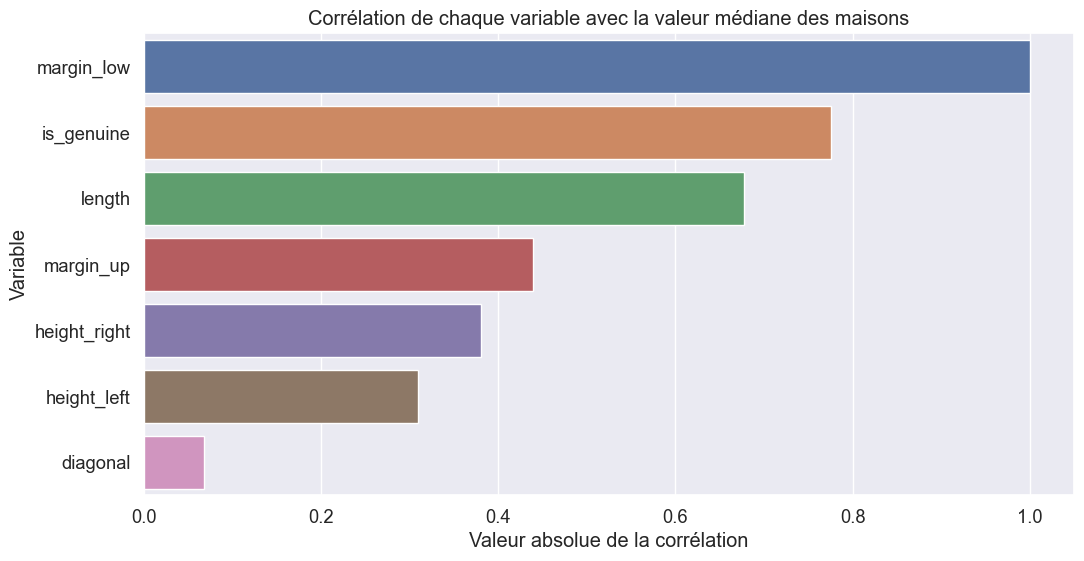

In [29]:
# Calcul de la corrélation entre chaque variable et la variable cible (en valeur absolue)
correlations = abs(train.corr()["margin_low"]).sort_values(ascending=False)

# Représentation graphique des corrélations
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Valeur absolue de la corrélation")
plt.ylabel("Variable")
plt.title("Corrélation de chaque variable avec la valeur médiane des maisons")
plt.show()

Comme vu précédemment c'est la variable length qui a le coefficient de corrélation le plus élevé avec margin_low. Au contraire, diagonal à le coeffecient de corréltion le plus faible.

#### Backward selection

In [30]:
#On utilise la fonction summary qui va nous donner plein d'informations sur le modèle
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     164.1
Date:                Sat, 12 Jul 2025   Prob (F-statistic):          6.87e-123
Time:                        16:00:45   Log-Likelihood:                -589.66
No. Observations:                 877   AIC:                             1191.
Df Residuals:                     871   BIC:                             1220.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4736      0.016    278.551      0.000       4.442       4.505
diagonal        -0.0155      0.016     -0.963      0.336      -0.047       0.016
height_left      0.0448      0.017      2.588      0.010       0.011       0.079
height_right     0.0812      0.018      4.611      0.000       0.047       0.116
margin_up        0.0562      0.019      2.916      0.004       0.018       0.094
length          -0.3691      0.020    -18.093      0.000      -0.409      -0.329
==============================================================================
Omnibus:                       43.028   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.428
Skew:                           0.488   Prob(JB):                     4.12e-12
Kurtosis:                       3.694   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La variable diagonal a une p-value > 0.05 indiquant une faible corrélation avec la variable à expliquer. Je relance mon modèle sans cette variable.

In [31]:
X_train_sans_diag = X_train_std.drop(columns='diagonal')
y_train_sans_diag = y_train.copy()

In [32]:
lr_model_sans_diag = sm.OLS(y_train_sans_diag, sm.add_constant(X_train_sans_diag)).fit()

In [33]:
lr_model_sans_diag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     204.9
Date:                Sat, 12 Jul 2025   Prob (F-statistic):          7.15e-124
Time:                        16:00:45   Log-Likelihood:                -590.13
No. Observations:                 877   AIC:                             1190.
Df Residuals:                     872   BIC:                             1214.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4736      0.016    278.562      0.000       4.442       4.505
height_left      0.0442      0.017      2.555      0.011       0.010       0.078
height_right     0.0811      0.018      4.606      0.000       0.047       0.116
margin_up        0.0559      0.019      2.904      0.004       0.018       0.094
length          -0.3706      0.020    -18.223      0.000      -0.411      -0.331
==============================================================================
Omnibus:                       43.497   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.170
Skew:                           0.491   Prob(JB):                     2.85e-12
Kurtosis:                       3.702   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le R² n'a pas bougé et plus aucune variable n'a de p-value > 0.05, je décide donc de continuer avec ces 4 variables.

In [34]:
X_test_sans_diag = X_test_std.drop(columns='diagonal')
y_test_sans_diag = y_test.copy()

In [35]:
# Obtention des prédictions et des métriques d'évaluation
y_train_sans_diag_pred = lr_model_sans_diag.predict(sm.add_constant(X_train_sans_diag))
y_test_sans_diag_pred = lr_model_sans_diag.predict(sm.add_constant(X_test_sans_diag))
r2_train_sans_diag = r2_score(y_train_sans_diag, y_train_sans_diag_pred)
r2_test_sans_diag = r2_score(y_test_sans_diag, y_test_sans_diag_pred)
mse_train_sans_diag = mean_squared_error(y_train_sans_diag, y_train_sans_diag_pred)
mse_test_sans_diag = mean_squared_error(y_test_sans_diag, y_test_sans_diag_pred)
rmse_train_sans_diag = np.sqrt(mse_train_sans_diag)
rmse_test_sans_diag = np.sqrt(mse_test_sans_diag)

In [36]:
# Construction du tableau de résultats

df_metrics = pd.DataFrame({
    'Métrique': ['R2', 'MSE', 'RMSE'],
    'train_sans_diag': [r2_train_sans_diag, mse_train_sans_diag, rmse_train_sans_diag],
    'test_sans_diag': [r2_test_sans_diag, mse_test_sans_diag, rmse_test_sans_diag]
})

print(df_metrics)

  Métrique  train_sans_diag  test_sans_diag
0       R2         0.484512        0.458396
1      MSE         0.224902        0.241474
2     RMSE         0.474238        0.491400


### Vérification des hypothèses du modèle

In [37]:
#Pour s'assurer de la fiabilité du modèle, il faut vérifier plusieurs hypothèses, notamment concernant les résidus qu'il faut donc calculer.
residuals = y_train_sans_diag - y_train_sans_diag_pred

#### linéarité

La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.

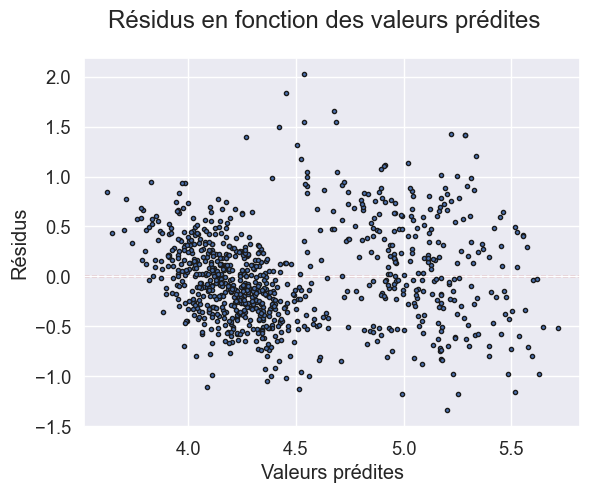

In [38]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=y_train_sans_diag_pred, y=residuals, marker='.', edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

Les valeurs ne sont pas centrées autour de 0 et il y a une sructure visible (2 groupes plus ou moins homogènes). Il n'y a donc pas linéarité.

**hypothèse rejetée**

#### homoscédasticité

Sur le graphique précédent, les points n'ont pas de valeurs constantes autour de l'axe des valeurs prédites et on peut distinguer une structure (2 groupes). Il y a donc pas homoscédasticité.

In [39]:
# On effectue un test statistique: le Test de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(lr_model_sans_diag.resid, lr_model_sans_diag.model.exog)
print("Test de Breusch-Pagan : statistique = %f, p-value = %f" % (bp_test[0], bp_test[1]))

Test de Breusch-Pagan : statistique = 41.865197, p-value = 0.000000


La p-value associée au test de Breusch-Pagan est de 0. Ceci nous pousse à rejeter l’hypothèse nulle d’homoscédasticité des résidus, confirmant ainsi l’idée qui ressort du graphique.

**Hypothèse rejetée**

#### multicolinéarité

In [40]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_sans_diag.values, i) for i in range(X_train_sans_diag.shape[1])]
vif["features"] = X_train_sans_diag.columns
print(vif)

   VIF Factor      features
0    1.160405   height_left
1    1.202756  height_right
2    1.437771     margin_up
3    1.603674        length


Les VIF se situent autour de 1, il n'y a donc pas de problème de colinéarité.

**Hypothèse acceptée**

#### normalité

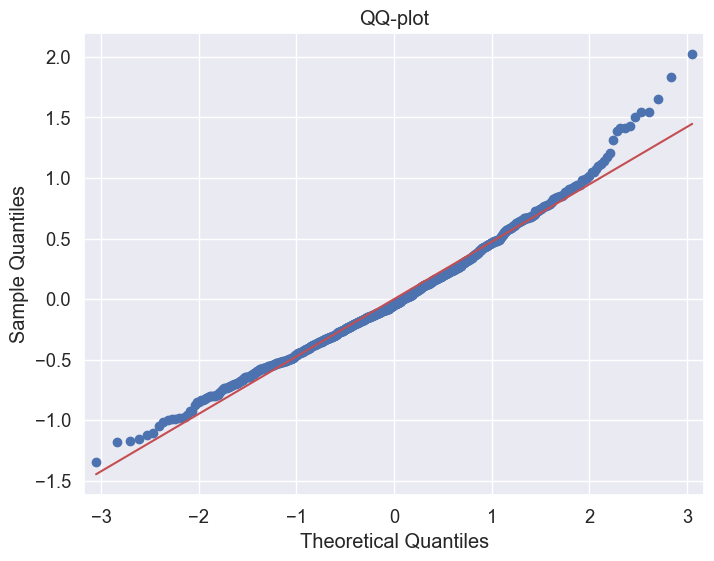

In [41]:
# QQ-plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ-plot')
plt.show()

On peut voir avec le QQ-plot que la distribution ne suit pas une distribution normale.

In [42]:
#On va tester cela avec des tests statistiques

# Comme on a un petit jeu de données, on utilise le Test de Shapiro-Wilk
shapiro_test = shapiro(residuals)

# Mettre les résultats dans un dataframe
print(f'Statistique: {shapiro_test.statistic}')
print(f'p-value: {shapiro_test.pvalue}')

Statistique: 0.9862687587738037
p-value: 2.546248367707449e-07


La p-value est < à 0.5 donc l'hypothèse 0 de normalité des résidus est rejetée.

**hypothèse rejetée**

#### autocorrélation

Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celui d’un autre. Même si cette hypothèse concerne plutôt les séries temporelles, on peut tout de même tracer les valeurs des résidus en fonction des observations.

Les résidus semblent répartis de manière aléatoire autour de 0. Pour confimer notre observation, on réalise un test de Durbin-Watson. Cette statistique est comprise entre 0 et 4 :
* si sa valeur est **proche de 0**, il y a une **autocorrélation positive** ;
* si sa valeur est **située autour de 2**, il n'y a **pas d’autocorrélation** ;
* si sa valeur est **proche de 4**, il y a une **autocorrélation négative**.

In [43]:
from statsmodels.stats.stattools import durbin_watson
# Test d'autocorrélation
dw_test = durbin_watson(lr_model.resid)
print("Test de Durbin-Watson : statistique = %f" % dw_test)

Test de Durbin-Watson : statistique = 1.968302


**hypothèse validée**

In [44]:
residuals.mean()

3.0341876230576684e-15

La moyenne des termes d'erreur est environ égale à 0, on peut donc accepter l'hypothèse.

**hypothèse validée**

### Imputation des valeurs manquantes

In [45]:
#on récupère les lignes où margin_low est null
df_missing = df[df['margin_low'].isna()].copy()
len(df_missing)

37

In [46]:
# On récupère les colonnes prédictives utiles (sans 'margin_low' ni 'is_genuine')
#Remarque: on garde diagonal pour le moment car elle faisait partie des X quand le scaler a été entraîné
X_missing = df_missing.drop(columns=['margin_low', 'is_genuine'])

In [47]:
#On standardise nos colonnes prédictives avec le scaler déjà entraîné sur les données d'entraînement
X_missing_std = pd.DataFrame(
    scaler.transform(X_missing), 
    index=X_missing.index, 
    columns=X_missing.columns
)

In [48]:
#on peut maintenant supprimer diagonal
X_missing_std = X_missing_std.drop(columns='diagonal')

In [49]:
#on prédit les valeurs manquantes
y_missing_pred = lr_model_sans_diag.predict(sm.add_constant(X_missing_std))

In [50]:
df_nett = df.copy()
df_nett.loc[df_nett['margin_low'].isna(), 'margin_low'] = y_missing_pred

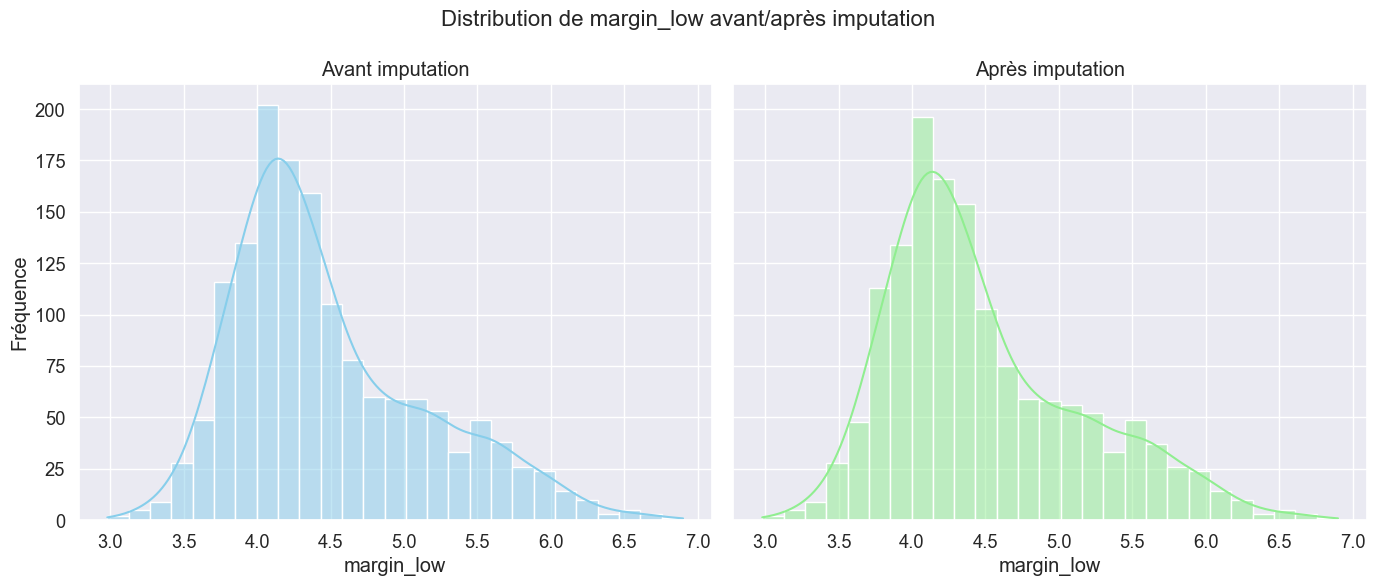

In [51]:
# Créer deux sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogramme avant imputation
sns.histplot(df_nett['margin_low'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Avant imputation')
axes[0].set_xlabel('margin_low')
axes[0].set_ylabel('Fréquence')

# Histogramme après imputation
sns.histplot(df['margin_low'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Après imputation')
axes[1].set_xlabel('margin_low')
axes[1].set_ylabel('')

# Afficher les deux graphiques
plt.suptitle('Distribution de margin_low avant/après imputation', fontsize=16)
plt.tight_layout()
plt.show()

La distribution de margin_low a peu changé, ce qui est logique étant donné le peu de valeurs manquantes (37) et le fait que le modèle s'adapte aux valeurs déjà existante dans le jeu de données.

# Analyse descriptive

Maintenant que l'on a une jeu de données sans valeurs manquantes, on peut faire une analyse descriptive pour tenter de le comprendre plus en détails.

## Calcul des centroïdes

In [52]:
df_nett.groupby('is_genuine').mean()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                
0           171.90116    104.19034     104.14362    5.213927    3.35016   
1           171.98708    103.94913     103.80865    4.117793    3.05213   

               length  
is_genuine             
0           111.63064  
1           113.20243

On peut voir à l'oeil nu qu'il y a des différences de dimensions physiques entre les vrais et les faux billets.

## Toile d'araignée

Je commence par tracer une toile d'araignée qui me permet de voir la répartition des valeurs moyennes pour chaque variable en fonction de la nature du billet.

In [53]:
# On va standardiser les données pour réduire l'effet taille
scaler_df = StandardScaler()
df_scaled = scaler_df.fit_transform(df_nett)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns
df_scaled['is_genuine'] = df['is_genuine']
df_scaled.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1 -0.486540     2.774123      3.163240    0.055843  -1.128325   
1           1 -1.633729    -2.236535     -0.799668   -1.081356  -0.696799   
2           1  2.397823     1.504756     -1.291191   -0.126109  -0.912562   
3           1 -1.961498    -0.399294      0.060498   -1.308796  -0.610494   
4           1 -0.748754     0.836669     -1.414072   -0.671965   1.417677   

     length  
0  0.173651  
1  0.471666  
2  0.551901  
3  0.953075  
4 -0.158750

In [54]:
#On calcule les centroïdes sur les données standardisées
mean_values = df_scaled.groupby('is_genuine').mean()
mean_values

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                               
0          -0.187746     0.537165      0.686023     1.10802   0.857384   
1           0.093873    -0.268582     -0.343012    -0.55401  -0.428692   

              length  
is_genuine            
0          -1.201070  
1           0.600535

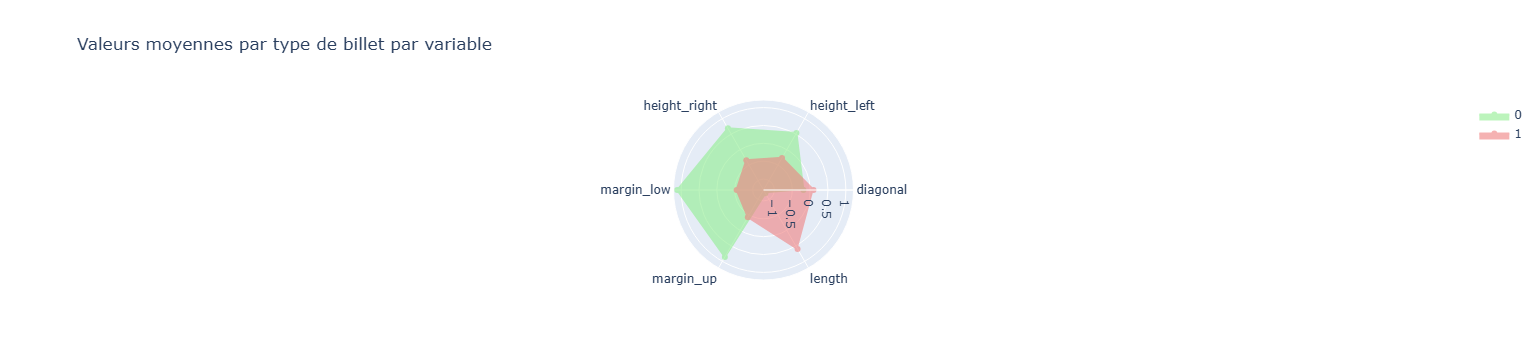

In [55]:
# Palette personnalisée
brand_colors = ["lightgreen","lightcoral"]

fig1 = go.Figure()

labels = mean_values.index

for i, label in enumerate(labels):
    r_values = mean_values.loc[label].values
    fig1.add_trace(
        go.Scatterpolar(
            r=r_values,
            theta=mean_values.columns,
            fill='toself',
            name=str(label),
            line=dict(color=brand_colors[i]),
            fillcolor=brand_colors[i],
            opacity=0.6  # un peu de transparence pour lisibilité
        )
    )
fig1.update_layout(
     showlegend=True,
    title=dict(text="Valeurs moyennes par type de billet par variable")  # texte général
)
    
fig1.show()

Les faux billets semblent surtout se distinguer des vrais billets par leur marge inférieure (plus élevée pour les faux que les vrais) et leur longueur (plus élevée pour les vrais que les faux). La diagonal en revanche ne semble pas être un facteur différenciant entre les vrais et les faux billets.

## Boxplot

J'approfondis mon analyse exploratoire avec des boxplots pour connaître le distribution de chacune de mes variables en fonction de la nature du billet.

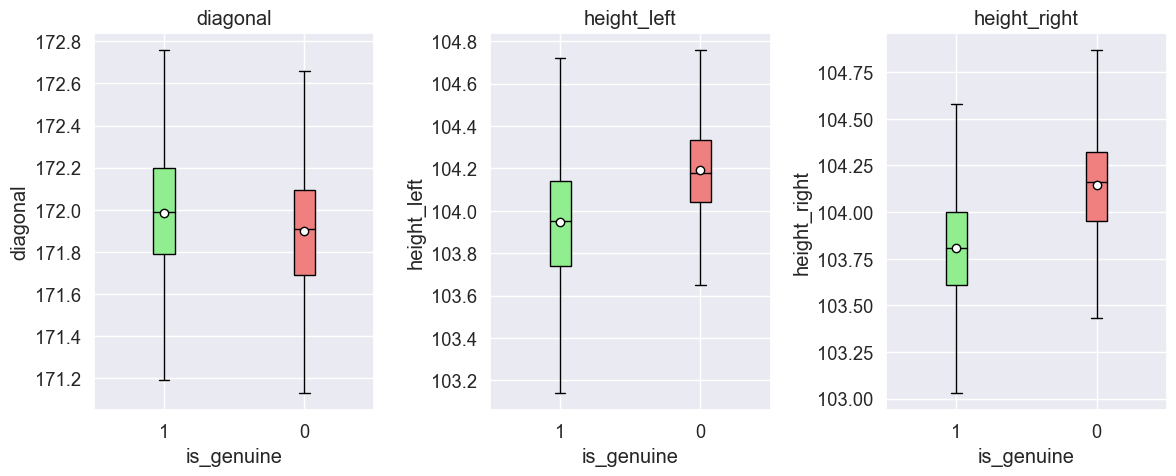

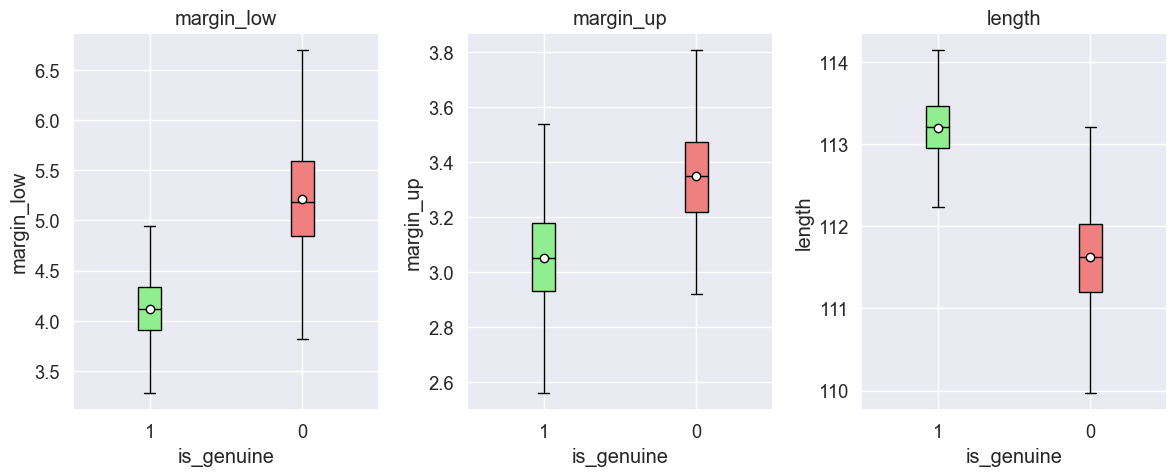

In [56]:
import matplotlib.pyplot as plt

X = "is_genuine"
Y = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]

medianprops = dict(color="black")
meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black')

# Mapping des modalités vers des couleurs
color_map = {
    True: "lightgreen",
    False: "lightcoral"
}

n_per_fig = 3

for i in range(0, len(Y), n_per_fig):
    fig, axes = plt.subplots(1, n_per_fig, figsize=(12, 5))

    # Gérer le cas d'une seule sous-figure
    if n_per_fig == 1 or len(Y) - i == 1:
        axes = [axes]

    for j, ax in enumerate(axes):
        characteristic_index = i + j
        if characteristic_index >= len(Y):
            break

        characteristic = Y[characteristic_index]
        modalites = df[X].unique()

        # Récupérer les groupes de données
        groupes = [df_nett[df_nett[X] == m][characteristic] for m in modalites]

        # Dessiner les boxplots
        box = ax.boxplot(
            groupes,
            labels=modalites,
            showfliers=False,
            medianprops=medianprops,
            patch_artist=True,
            showmeans=True,
            meanprops=meanprops
        )

        # Colorer chaque boîte selon la modalité
        for patch, m in zip(box['boxes'], modalites):
            patch.set_facecolor(color_map[m])

        ax.set_title(characteristic)
        ax.set_xlabel(X)
        ax.set_ylabel(characteristic)

    plt.tight_layout()
    plt.show()

## Tests statistiques

Pour une interprétation plus rigoureuse, je réalise des tests statistiques pour mesurer l'influence des dimensions du billet sur sa nature

### Question

### Choix du test statistique et du seuil de risque

### Hypothèses

H0 : pas de différence de moyenne entre les deux groupes.
Ha : différence de moyenne entre les deux groupes.

### Test de normalité

In [57]:
for characteristic in Y:
    group_true = df_nett[df_nett[X] == True][characteristic]
    group_false = df_nett[df_nett[X] == False][characteristic]
    
    stat_true, p_true = shapiro(group_true)
    stat_false, p_false = shapiro(group_false)
    
    print(f"{characteristic}:")
    print(f"  Groupe True  - p-value = {p_true:.4f} {'(normal)' if p_true > 0.05 else '(non normal)'}")
    print(f"  Groupe False - p-value = {p_false:.4f} {'(normal)' if p_false > 0.05 else '(non normal)'}\n")

diagonal:
  Groupe True  - p-value = 0.3102 (normal)
  Groupe False - p-value = 0.6388 (normal)

height_left:
  Groupe True  - p-value = 0.0285 (non normal)
  Groupe False - p-value = 0.7906 (normal)

height_right:
  Groupe True  - p-value = 0.5872 (normal)
  Groupe False - p-value = 0.8266 (normal)

margin_low:
  Groupe True  - p-value = 0.4353 (normal)
  Groupe False - p-value = 0.5098 (normal)

margin_up:
  Groupe True  - p-value = 0.3552 (normal)
  Groupe False - p-value = 0.1926 (normal)

length:
  Groupe True  - p-value = 0.3036 (normal)
  Groupe False - p-value = 0.5268 (normal)



Mes distributions sont normales, je peux utiliser mon test paramétrique.

### Exécution du test

In [58]:
results = []

for characteristic in Y:
    group_true = df_nett[df_nett[X] == 1][characteristic]
    group_false = df_nett[df_nett[X] == 0][characteristic]

    t_stat, p_value = ttest_ind(group_true, group_false, equal_var=False)  # Welch's t-test
    results.append({
        "caractéristique": characteristic,
        "t_statistique": round(t_stat, 3),
        "p_value": round(p_value, 4),
        "différence_significative": p_value < 0.05
    })

result_df = pd.DataFrame(results)
print(result_df)

  caractéristique  t_statistique  p_value  différence_significative
0        diagonal          5.148      0.0                      True
1     height_left        -17.487      0.0                      True
2    height_right        -22.003      0.0                      True
3      margin_low        -41.226      0.0                      True
4       margin_up        -29.821      0.0                      True
5          length         52.774      0.0                      True


## ACP

Enfin, nous allons chercher à comprendre les liens entre les variables et les individus en réalisant une ACP. Elle aura donc ici plutôt une visée interprétative plutôt que de chercher à faire une réduction dimensionnelle.

### Récupération de la matrice et des variables

In [59]:
#Nous récupérons la matrice de données centrée-réduite
df_scaled.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1 -0.486540     2.774123      3.163240    0.055843  -1.128325   
1           1 -1.633729    -2.236535     -0.799668   -1.081356  -0.696799   
2           1  2.397823     1.504756     -1.291191   -0.126109  -0.912562   
3           1 -1.961498    -0.399294      0.060498   -1.308796  -0.610494   
4           1 -0.748754     0.836669     -1.414072   -0.671965   1.417677   

     length  
0  0.173651  
1  0.471666  
2  0.551901  
3  0.953075  
4 -0.158750

In [60]:
#supression de la colonne is_genuine

df_scaled_acp = df_scaled.drop(columns='is_genuine')
df_scaled_acp.head()

diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.055843  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.081356  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.126109  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.308796  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.671965   1.417677 -0.158750

In [61]:
names = df_scaled_acp.index
names

RangeIndex(start=0, stop=1500, step=1)

In [62]:
features = df_scaled_acp.columns
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

### Application de l'ACP

In [63]:
#Nous n'allons travailler que sur les 6 premières composantes : 
n_components = 6

In [64]:
#On instancie notre ACP : 
pca = PCA(n_components=n_components)

In [65]:
#On l'entraine sur les données scalées : 
pca.fit(df_scaled_acp)

PCA(n_components=6)

### Variance expliquée et éboulis des valeurs propres

In [66]:
#Intéressons nous maintenant à la variance *captée* par chaque nouvelle composante.
pca.explained_variance_ratio_

array([0.43287023, 0.16953984, 0.13026477, 0.11826874, 0.09606743,
       0.05298898])

In [67]:
#Enregistrons cela dans une variable : 
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.29, 16.95, 13.03, 11.83,  9.61,  5.3 ])

In [68]:
#On calcule la somme cumulée de la variance expliquée
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

In [69]:
#Définisons ensuite une variable avec la liste de nos composantes : 
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

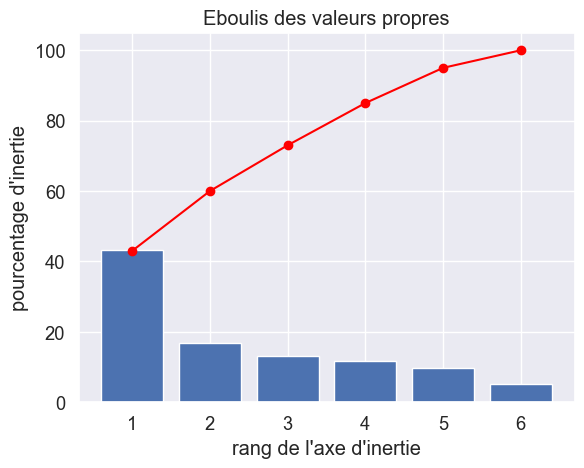

In [70]:
#On peut enfin l'afficher de façon graphique
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

### Composantes

Nous allons calculer la contribution de chaque variable à la construction des axes factoriels.

In [71]:
pcs = pd.DataFrame(pca.components_)
pcs

0         1         2         3         4         5
0  0.084311 -0.330657 -0.393451 -0.507677 -0.439484  0.527136
1  0.941630  0.306938  0.107790 -0.071151 -0.005734  0.049077
2 -0.287774  0.885246 -0.161904 -0.110129 -0.269976  0.149323
3 -0.101736 -0.050167  0.867587 -0.091353 -0.441634  0.176184
4 -0.114064  0.101187  0.233784 -0.563869  0.713599  0.308099
5  0.007121  0.006234  0.001858  0.631491  0.172251  0.755947

In [72]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

diagonal  height_left  height_right  margin_low  margin_up  length
F1      0.08        -0.33         -0.39       -0.51      -0.44    0.53
F2      0.94         0.31          0.11       -0.07      -0.01    0.05
F3     -0.29         0.89         -0.16       -0.11      -0.27    0.15
F4     -0.10        -0.05          0.87       -0.09      -0.44    0.18
F5     -0.11         0.10          0.23       -0.56       0.71    0.31
F6      0.01         0.01          0.00        0.63       0.17    0.76

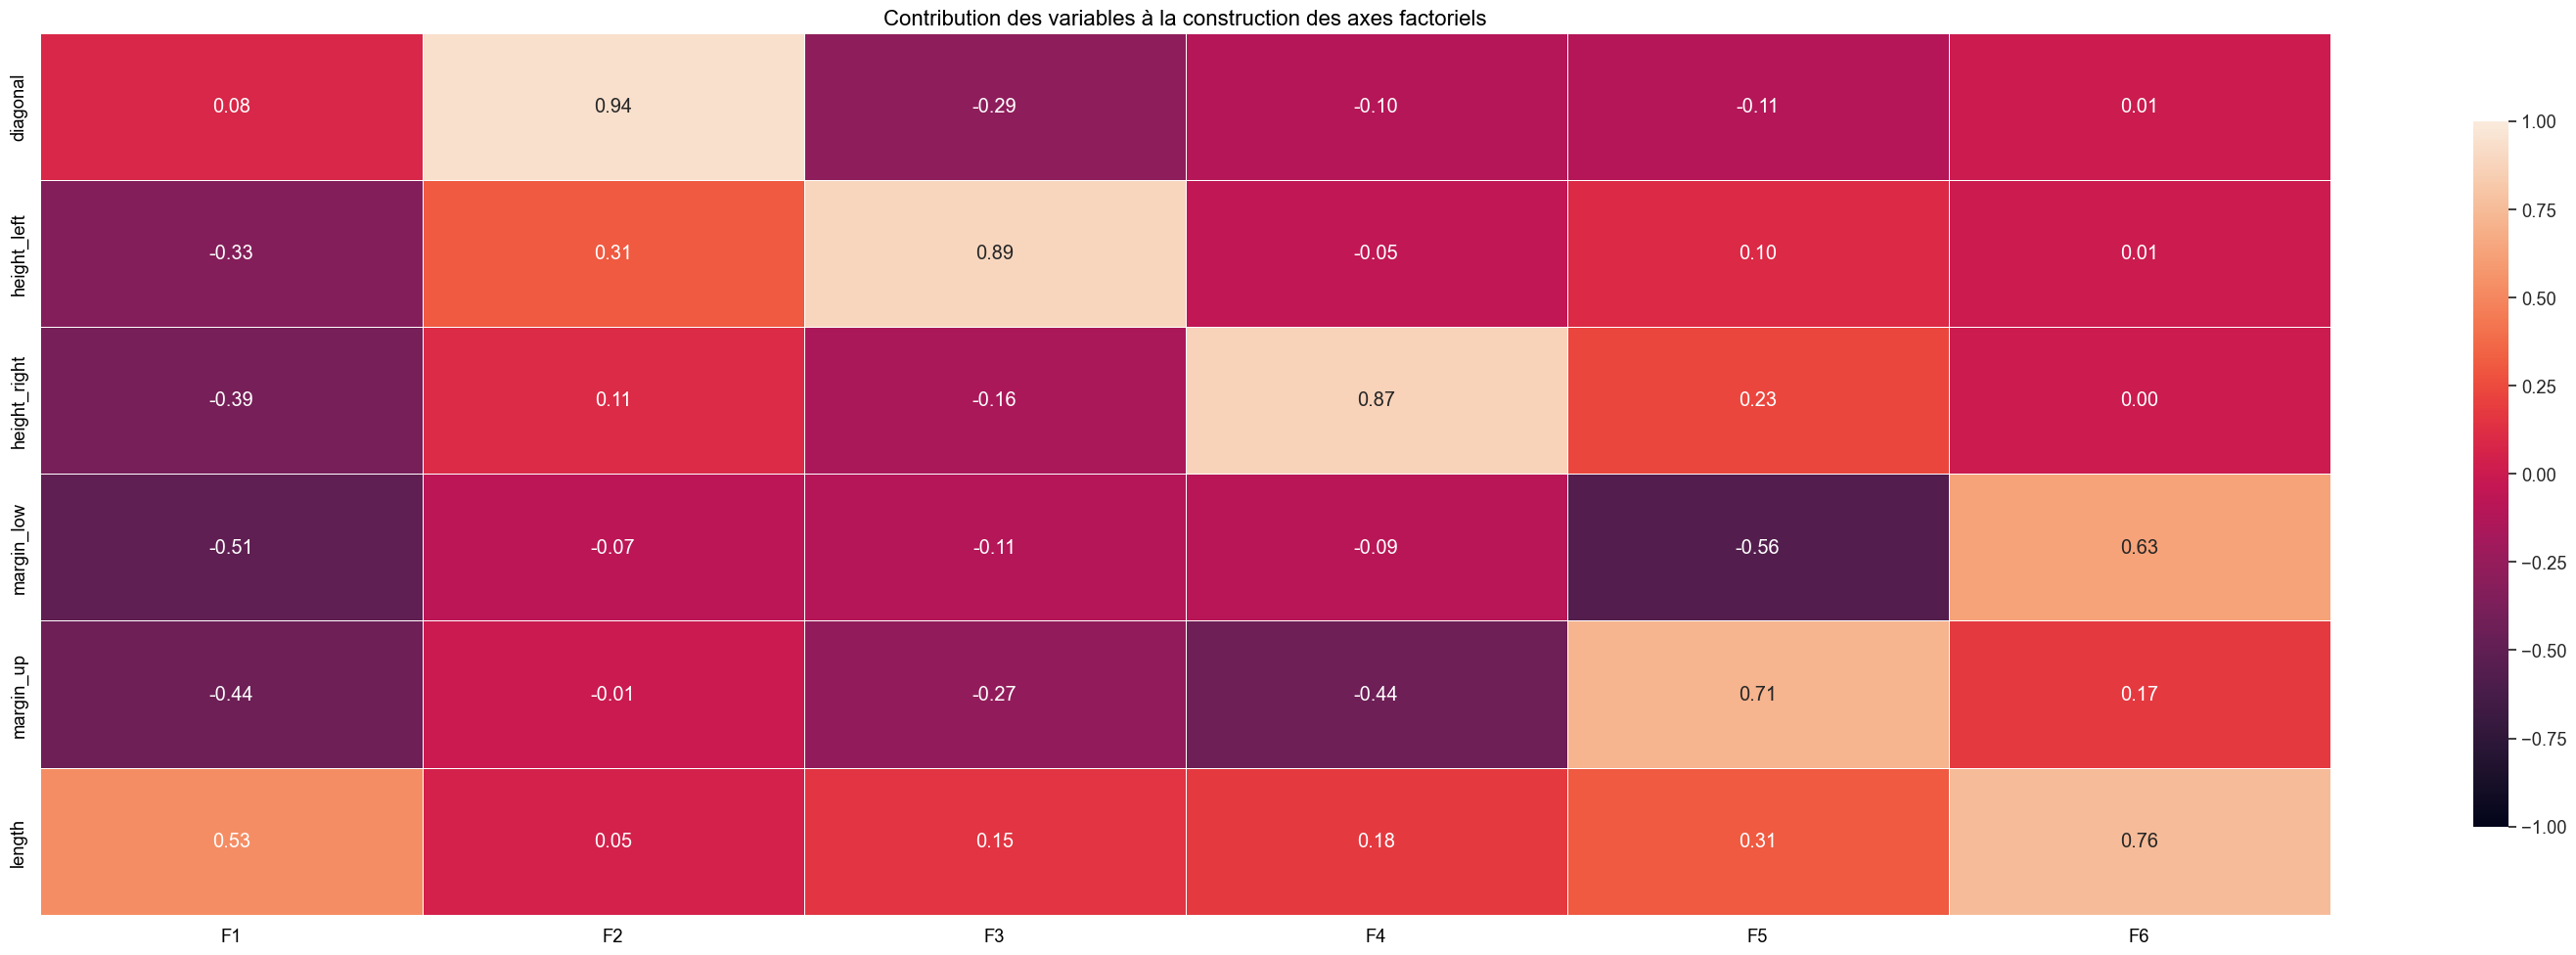

In [73]:
# Tracer la heatmap
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(
    pcs.T,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

# Bordures et ticks en noir
ax.tick_params(axis='both', colors="#000000")
for spine in ax.spines.values():
    spine.set_edgecolor("#0100ac")
    
plt.title("Contribution des variables à la construction des axes factoriels", fontsize=16, color="#000000")

plt.tight_layout()
plt.show()

### Graph des corrélation

In [74]:
#On importe la fonction stockée dans utils

from utils import correlation_graph

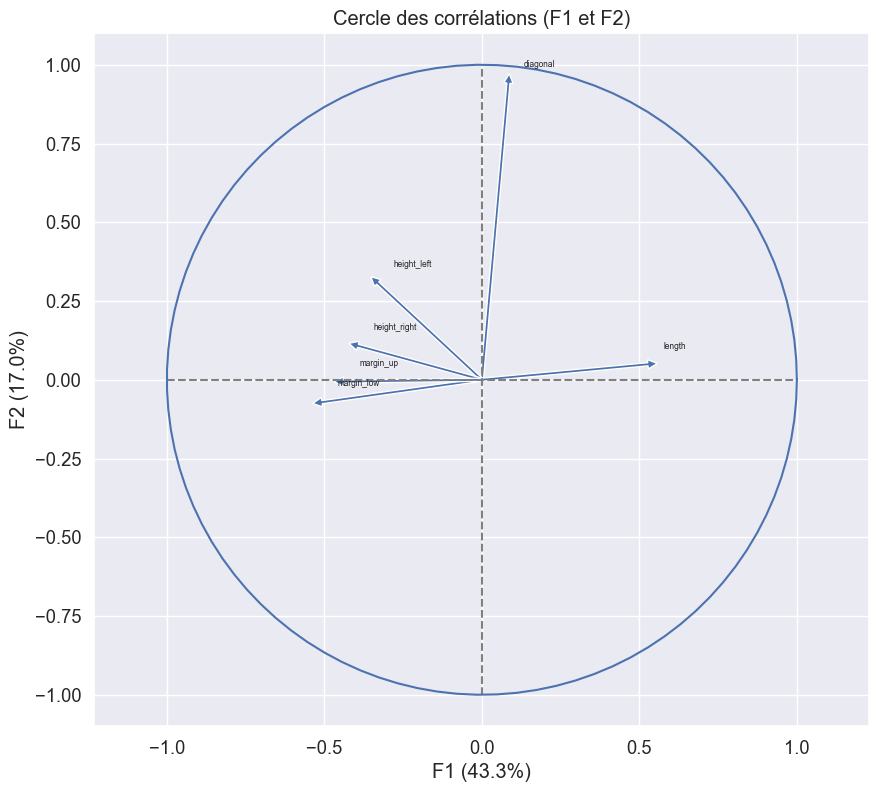

In [75]:
correlation_graph(pca, (0,1), features)

Les variables les plus corrélées à F1 sont length (positivement) et margin_low (négativement).
La variable la plus corrélée à F2 est diagonal (positivement).

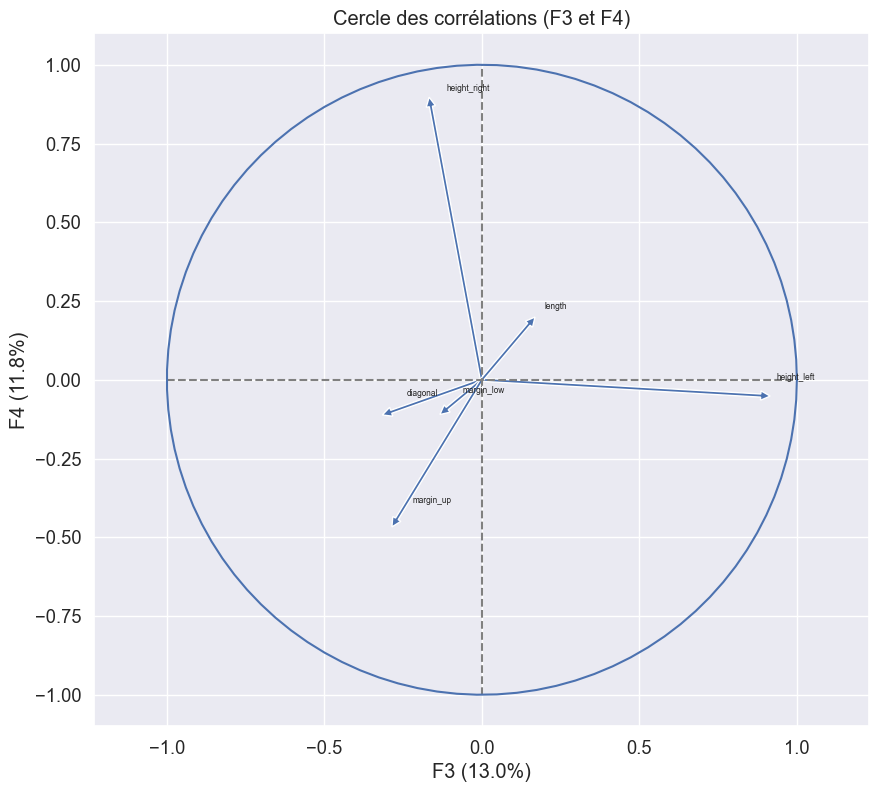

In [76]:
correlation_graph(pca, (2,3), features)

La variable la plus corrélée à F3 est height_left (positivement).
La variable la plus corrélée à F4 est height_right (positivement).

### Graph des individus

In [77]:
X_proj = pca.transform(df_scaled_acp)
X_proj[:5]

array([[-1.64381416,  0.74532668,  2.40805329,  3.17851336,  0.29255852,
        -0.00811444],
       [ 2.02025911, -2.20695905, -1.00263169,  0.07424319,  0.03091976,
        -0.47339877],
       [ 0.96863022,  2.62184259,  1.19376865, -0.92787892, -0.83315668,
         0.20443915],
       [ 1.37799888, -1.819646  ,  0.65247078,  0.82916739,  0.79345905,
        -0.22752115],
       [-0.14899991, -0.56877554,  0.85263331, -1.78530556,  1.18112044,
        -0.30289212]])

In [78]:
#On importe la fonction stockée dans utils

from utils import display_factorial_planes

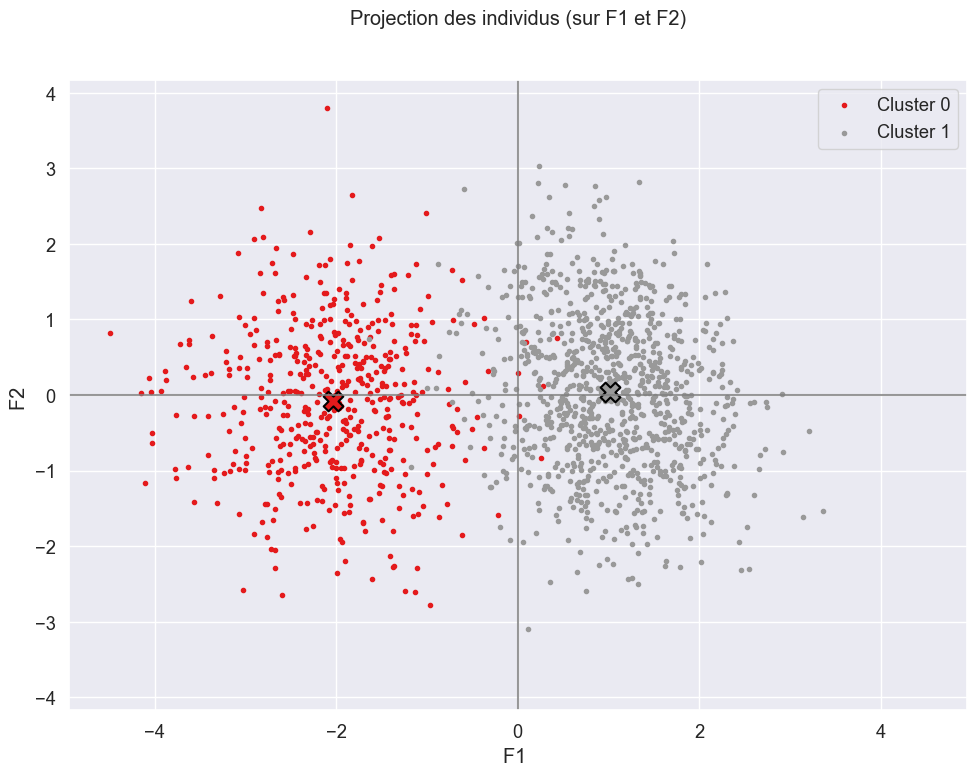

In [79]:
x_y = [0,1]

display_factorial_planes(X_proj,
                         x_y,
                         clusters=df_nett['is_genuine'],
                         show_centroids=True)

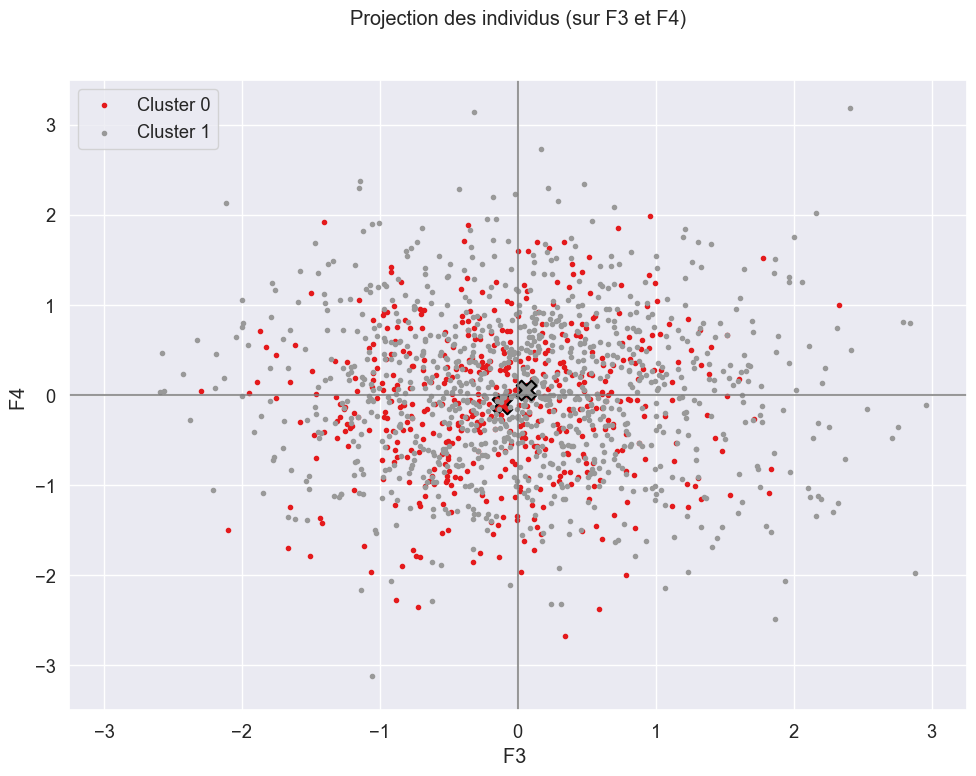

In [80]:
x_y = [2,3]

display_factorial_planes(X_proj,
                         x_y,
                         clusters=df['is_genuine'],
                         show_centroids=True)

Nous avons vu que l'axe F3 est corrélé à height_left cependant on ne distingue pas de séparation des clusters sur l'axe horizontal indiquant que cette variable n'a pas d'effet sur les vrais/faux billets.

Il en est de même pour la variable height_right fortement corrélée à l'axe F4.

# Export des jeux de données

In [83]:
df_scaled.to_csv('df_scaled.csv', index=False)

In [82]:
df_nett.to_csv('df.csv', index=False)